In [1]:

import os
import numpy as np
import cv2
import time
from datetime import datetime
from utils.utils import get_yolo_boxes,read_annotations
from utils.evaluate import evaluate_mAP
from utils.bbox import draw_boxes,draw_boxes_gt
from keras.models import load_model
from model import model, dummy_loss
from utils.generator import create_batch
from utils.utils import normalize, evaluate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"    
os.environ['CUDA_VISIBLE_DEVICES'] = "" 
anchors = [19,22, 20,22, 22,23, 27,38, 28,28, 34,22, 39,31, 39,41, 49,48]

#[24,26, 33,47, 38,38, 40,29, 46,48, 50,60, 52,39, 59,52, 66,67]  net_size = 736
#[19,22, 20,22, 22,23, 27,38, 28,28, 34,22, 39,31, 39,41, 49,48]  net_size = 544
#[11,13, 14,15, 16,24, 18,18, 21,21, 22,14, 25,27, 27,21, 31,31]  net_size = 352
#[7,7, 10,8, 10,14, 10,11, 12,11, 13,15, 16,11, 17,16, 20,20]     net_size = 224
net_size = 544
net_h, net_w = net_size,net_size
_, infer_model = model(
            nb_class            = 1, 
            anchors             = anchors, 
            max_grid            = [net_h, net_w])
infer_model.summary()


/Users/sam/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/sam/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 2 648         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 2 96          conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 2 0           bnorm_0[0][0]                    
__________________________________________________________________________________________________
conv_1_0 (

In [2]:
import xml.etree.ElementTree as ET
def get_gt(xml_file, labels=[]):
    '''get single image annotations for annotated images'''
    seen_labels = {}
    img = {'object':[]}
    if '.xml' in xml_file:
        
        img['filename'] = xml_file[:-3]+'jpg'
        tree = ET.parse(xml_file) 
        
        for node in tree.iter('object'):

            obj = []
            for attr in node:

                if 'name' in attr.tag or 'label' in attr.tag:

                    obj.append('mp')

                    if obj[0] in seen_labels:
                        seen_labels[obj[0]] += 1
                    else:
                        seen_labels[obj[0]] = 1

                    if len(labels) > 0 and (obj[0] not in labels):
                        break

                if 'bndbox' in attr.tag:

                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            obj.append(int(float(dim.text)))
                        if 'ymin' in dim.tag:
                            obj.append(int(float(dim.text)))
                        if 'xmax' in dim.tag:
                            obj.append(int(float(dim.text)))
                        if 'ymax' in dim.tag:
                            obj.append(int(float(dim.text)))

            img['object'].append(obj)

           
    return img, seen_labels


In [3]:
#Load weights
saved_weights_name  = 'weights/weights_phone_dataset/weights_480-608.h5'
saved_weights_name1  = 'saved_weights_2016/saved-weights-544.h5'
infer_model.load_weights(saved_weights_name)



Predicted: 33, Ground truth: 27


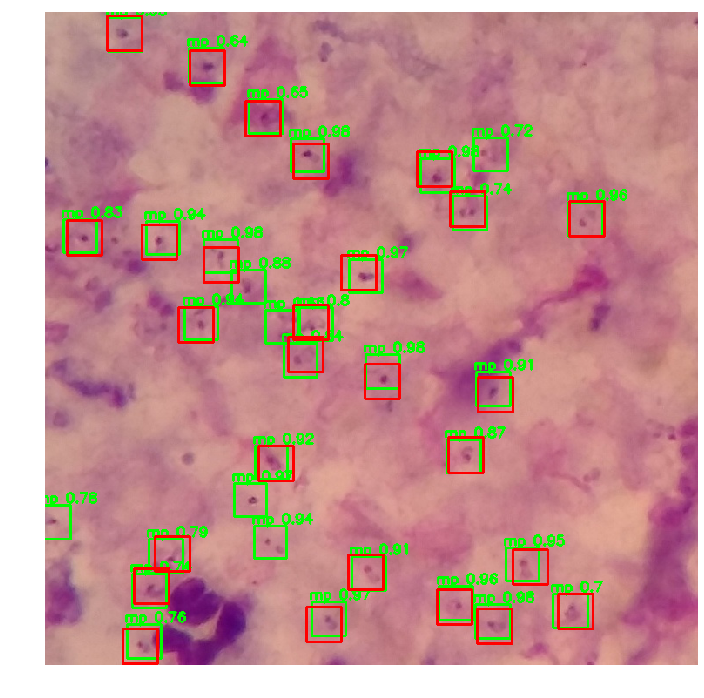

0.4054899215698242


In [10]:
import time

obj_thresh, nms_thresh = .5, 0.05
LABELS =['mp']
image_path = 'plasmodium-phone-0178.jpg'
size = 544
net_h, net_w =size,size
start_time = datetime.now()
image = cv2.imread(image_path)
plt.figure(figsize=(12,12))
# predict the bounding boxes
start = time.time()
predicted_boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors , obj_thresh, nms_thresh)[0]
end = time.time()

#draw ground truth data
grdt_boxes = get_gt(image_path[:-3]+'xml')[0]['object']
# draw bounding boxes on the image using labels
image,pred_boxes = draw_boxes(image, predicted_boxes, ['mp'], obj_thresh) 
image = draw_boxes_gt(image,grdt_boxes)
print("Predicted: "+str(len(pred_boxes))+', Ground truth: '+str(len(grdt_boxes)))
plt.imshow(image[:,:,::-1]); 
plt.axis('off')
plt.show()


print(end - start)


## Evauate mAP for entire dataset

Average detection time:  0.1861149933985892
map: 56.93
avg precs:  [0.8922, 0.8831, 0.8806, 0.8537, 0.7335, 0.5199, 0.2496, 0.0889, 0.0218]
iou_thrs:   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Plotting and calculating mAP takes 8.9400 secs


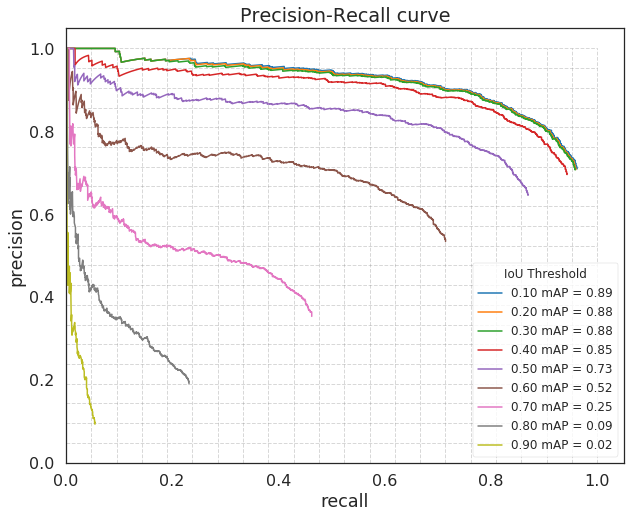

In [14]:

def predict_boxes():
    LABELS =['mp']
    test_annot_folder  = 'data/malaria_phone_dataset/test/'
    test_image_folder  = 'data/malaria_phone_dataset/test/'
    test_cache_name    = 'data/test_malaria_phone_dataset.pkl'
    av_time =0
    i = 0
    test_imgs, train_labels = read_annotations(test_annot_folder, test_image_folder, test_cache_name, LABELS)
    ground_truth_boxes = {}
    predicted_boxes    = {}
    for img in test_imgs:
        
        # get predict boxes
        #dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
        filename = img['filename']
        image = cv2.imread(filename)
        start = time.time()
        pd_boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors , obj_thresh, nms_thresh)[0]
        
        # process predict boxes
        pred_bb = []
        pred_cls = []
        pred_conf = []
        if len(pd_boxes)>0:
            
            for box in pd_boxes:
                
                if box.classes[0] > obj_thresh:#getting prediction with more than threshold
                    xmin = box.xmin
                    xmax = box.xmax
                    ymin = box.ymin
                    ymax = box.ymax
                    pred_conf.append(box.get_score())

                    if filename in predicted_boxes:
                        predicted_boxes[filename]['boxes'].append([xmin, ymin, xmax, ymax])
                        predicted_boxes[filename]['scores'].append(box.get_score())
                    else:
                        predicted_boxes[filename]={'boxes':[[xmin, ymin, xmax, ymax]],
                                                   'scores':[box.get_score()]}
        else:

            predicted_boxes[filename]={'boxes':[],'scores':[] }

        end = time.time()
        av_time +=(end - start) 
        i +=1
        
        # process ground truth box        
        objects = img['object']
        for obj in objects:
            xmin = obj['xmin']
            xmax = obj['xmax']
            ymin = obj['ymin']
            ymax = obj['ymax']
            
            if filename in ground_truth_boxes:
                ground_truth_boxes[filename].append([xmin, ymin, xmax, ymax])
            else:
                ground_truth_boxes[filename]=[[xmin, ymin, xmax, ymax]]
    print('Average detection time: ', av_time/i)                                         
    return ground_truth_boxes, predicted_boxes 

gt_boxes,pred_boxes =  predict_boxes()
iou_thresholds= np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
d=evaluate_mAP(gt_boxes, pred_boxes, iou_thresholds)